# Climate-Food Security Modeling Pipeline
## Phase 1-2: Data Preparation and Preprocessing
### Creating Master Datasets for FNN, LSTM, and Hybrid Models

This notebook implements data preparation following the exact structure in `file_structure.md`:
- Loads raw data from all 6 geopolitical zones (state-level)
- Creates three master datasets:
  - `master_data_fnn.csv` - Annual aggregated for Feedforward Neural Networks
  - `master_data_lstm.csv` - Monthly time-series for LSTM models
  - `master_data_hybrid.csv` - Monthly + Static features for Hybrid models
- Implements proper temporal splits: Train (1990-2016), Val (2017-2019), Test (2020-2023)

---
## Setup and Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

print("✓ Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ Libraries imported successfully!
Pandas version: 2.2.3
NumPy version: 2.1.3


---
## 1. Load Raw Data

In [2]:
# Define data paths
BASE_PATH = Path('project_data/raw_data')
CLIMATE_PATH = BASE_PATH / 'climate'
SOIL_PATH = BASE_PATH / 'soil'
AGRICULTURE_PATH = BASE_PATH / 'agriculture'

print("Loading raw data from:")
print(f"  Climate: {CLIMATE_PATH}")
print(f"  Soil: {SOIL_PATH}")
print(f"  Agriculture: {AGRICULTURE_PATH}")
print("\n" + "="*80)

Loading raw data from:
  Climate: project_data\raw_data\climate
  Soil: project_data\raw_data\soil
  Agriculture: project_data\raw_data\agriculture



In [3]:
# Load climate datasets
print("\n1. Loading climate data...")
co2_df = pd.read_csv(CLIMATE_PATH / 'co2_data.csv')
temp_df = pd.read_csv(CLIMATE_PATH / 'temperature_data.csv')
rain_df = pd.read_csv(CLIMATE_PATH / 'rainfall_data.csv')
humidity_df = pd.read_csv(CLIMATE_PATH / 'humidity_data.csv')

print(f"  ✓ CO2 data: {co2_df.shape}")
print(f"  ✓ Temperature data: {temp_df.shape}")
print(f"  ✓ Rainfall data: {rain_df.shape}")
print(f"  ✓ Humidity data: {humidity_df.shape}")


1. Loading climate data...
  ✓ CO2 data: (408, 4)
  ✓ Temperature data: (7344, 11)
  ✓ Rainfall data: (7344, 11)
  ✓ Humidity data: (7344, 8)


In [4]:
# Load soil data
print("\n2. Loading soil data...")
soil_df = pd.read_csv(SOIL_PATH / 'nigeria_soil_complete.csv')
print(f"  ✓ Soil data: {soil_df.shape}")
print(f"  ✓ Geopolitical zones: {soil_df['Geopolitical_Zone'].nunique()}")
print(f"  ✓ States: {soil_df['State'].nunique()}")


2. Loading soil data...
  ✓ Soil data: (18, 15)
  ✓ Geopolitical zones: 6
  ✓ States: 18


In [5]:
# Load FAO crop data
print("\n3. Loading agricultural data...")
fao_df = pd.read_csv(AGRICULTURE_PATH / 'fao_crop_yield_raw.csv')
print(f"  ✓ FAO crop data: {fao_df.shape}")
print(f"  ✓ Years: {fao_df['Year'].min()} - {fao_df['Year'].max()}")

print("\n" + "="*80)
print("✓ All raw data loaded successfully!")


3. Loading agricultural data...
  ✓ FAO crop data: (612, 15)
  ✓ Years: 1990 - 2023

✓ All raw data loaded successfully!


---
## 2. Data Cleaning and Validation

In [6]:
# Convert date columns to datetime
print("Converting date columns...")
temp_df['Date'] = pd.to_datetime(temp_df['Date'])
rain_df['Date'] = pd.to_datetime(rain_df['Date'])
humidity_df['Date'] = pd.to_datetime(humidity_df['Date'])

print("  ✓ Date columns converted to datetime")

Converting date columns...
  ✓ Date columns converted to datetime


In [7]:
# Check for missing values
print("\nChecking for missing values...")
print(f"  CO2: {co2_df.isnull().sum().sum()} missing")
print(f"  Temperature: {temp_df.isnull().sum().sum()} missing")
print(f"  Rainfall: {rain_df.isnull().sum().sum()} missing")
print(f"  Humidity: {humidity_df.isnull().sum().sum()} missing")
print(f"  Soil: {soil_df.isnull().sum().sum()} missing")
print(f"  FAO: {fao_df.isnull().sum().sum()} missing")


Checking for missing values...
  CO2: 144 missing
  Temperature: 0 missing
  Rainfall: 0 missing
  Humidity: 0 missing
  Soil: 0 missing
  FAO: 597 missing


In [8]:
# Handle sentinel values
print("\nRemoving sentinel values (-9999, -999)...")
for df in [temp_df, rain_df, humidity_df]:
    df.replace([-9999, -999], np.nan, inplace=True)
print("  ✓ Sentinel values replaced with NaN")


Removing sentinel values (-9999, -999)...
  ✓ Sentinel values replaced with NaN


In [9]:
# Verify geopolitical zones
print("\nVerifying geopolitical zones...")
zones = ['North-West', 'North-East', 'North-Central', 'South-West', 'South-East', 'South-South']

temp_zones = set(temp_df['Geopolitical_Zone'].unique())
soil_zones = set(soil_df['Geopolitical_Zone'].unique())

print(f"  Temperature data zones: {temp_zones}")
print(f"  Soil data zones: {soil_zones}")
print(f"  All 6 zones present: {len(temp_zones) == 6 and len(soil_zones) == 6}")


Verifying geopolitical zones...
  Temperature data zones: {'South-East', 'North-Central', 'South-South', 'North-West', 'North-East', 'South-West'}
  Soil data zones: {'South-East', 'North-Central', 'South-South', 'North-West', 'North-East', 'South-West'}
  All 6 zones present: True


---
## 3. Process FAO Crop Data

In [10]:
# Filter for Nigeria only
print("Processing FAO crop data...")
fao_nigeria = fao_df[fao_df['Area'] == 'Nigeria'].copy()
print(f"  ✓ Nigeria records: {len(fao_nigeria)}")

# Check available elements
print(f"\n  Available elements: {fao_nigeria['Element'].unique()}")
print(f"  Available crops: {fao_nigeria['Item'].nunique()}")

Processing FAO crop data...
  ✓ Nigeria records: 612

  Available elements: ['Area harvested' 'Yield' 'Production']
  Available crops: 6


In [11]:
# Calculate crop yields
print("\nCalculating crop yields...")

# Separate production and area data
production = fao_nigeria[fao_nigeria['Element'] == 'Production'].copy()
area_harvested = fao_nigeria[fao_nigeria['Element'] == 'Area harvested'].copy()

print(f"  Production records: {len(production)}")
print(f"  Area harvested records: {len(area_harvested)}")

# Merge to calculate yield
yield_data = production.merge(
    area_harvested[['Year', 'Item', 'Value']],
    on=['Year', 'Item'],
    suffixes=('_production', '_area')
)

# Calculate yield (tonnes per hectare)
# FAO production is in tonnes, area in hectares
yield_data['Yield_tonnes_per_ha'] = yield_data['Value_production'] / yield_data['Value_area']

# Keep relevant columns
yield_data = yield_data[['Year', 'Item', 'Value_production', 'Value_area', 'Yield_tonnes_per_ha']].copy()
yield_data.columns = ['Year', 'Crop', 'Production_tonnes', 'Area_ha', 'Yield_tonnes_per_ha']

print(f"\n  ✓ Yield data calculated: {yield_data.shape}")
print(f"  ✓ Crops with yield data: {yield_data['Crop'].nunique()}")
print(f"  ✓ Year range: {yield_data['Year'].min()} - {yield_data['Year'].max()}")


Calculating crop yields...
  Production records: 204
  Area harvested records: 204

  ✓ Yield data calculated: (204, 5)
  ✓ Crops with yield data: 6
  ✓ Year range: 1990 - 2023


In [12]:
# Focus on major crops by zone
major_crops = [
    'Maize', 'Rice, paddy', 'Cassava', 'Yams', 'Sorghum', 'Millet',
    'Groundnuts, with shell', 'Cowpeas, dry'
]

yield_data_filtered = yield_data[yield_data['Crop'].isin(major_crops)].copy()
print(f"\nFiltered to major crops:")
print(f"  Crops: {yield_data_filtered['Crop'].nunique()}")
print(f"  Records: {len(yield_data_filtered)}")

print(f"\nCrop distribution:")
print(yield_data_filtered['Crop'].value_counts())


Filtered to major crops:
  Crops: 3
  Records: 102

Crop distribution:
Crop
Millet     34
Sorghum    34
Yams       34
Name: count, dtype: int64


---
## 4. Merge Climate Data

In [13]:
# Merge all climate variables
print("Merging climate datasets...")

# Start with temperature
climate_monthly = temp_df.copy()
print(f"  Starting with temperature: {climate_monthly.shape}")

# Merge rainfall
climate_monthly = climate_monthly.merge(
    rain_df,
    on=['Date', 'Year', 'Month', 'Geopolitical_Zone', 'State'],
    how='outer'
)
print(f"  After rainfall merge: {climate_monthly.shape}")

# Merge humidity
climate_monthly = climate_monthly.merge(
    humidity_df,
    on=['Date', 'Year', 'Month', 'Geopolitical_Zone', 'State'],
    how='outer'
)
print(f"  After humidity merge: {climate_monthly.shape}")

# Add CO2 (national level)
climate_monthly = climate_monthly.merge(
    co2_df,
    on=['Year', 'Month'],
    how='left'
)
print(f"  After CO2 merge: {climate_monthly.shape}")

print("\n  ✓ All climate data merged successfully!")

Merging climate datasets...
  Starting with temperature: (7344, 11)
  After rainfall merge: (7344, 17)
  After humidity merge: (7344, 20)
  After CO2 merge: (7344, 22)

  ✓ All climate data merged successfully!


In [14]:
# Add soil data
print("\nAdding soil properties...")
climate_monthly = climate_monthly.merge(
    soil_df,
    on=['Geopolitical_Zone', 'State'],
    how='left'
)

print(f"  ✓ Climate + Soil merged: {climate_monthly.shape}")
print(f"  ✓ Columns: {len(climate_monthly.columns)}")


Adding soil properties...
  ✓ Climate + Soil merged: (7344, 35)
  ✓ Columns: 35


---
## 5. Define Growing Seasons by Zone

In [15]:
# Define growing seasons for each geopolitical zone
growing_seasons = {
    'North-West': {'start': 5, 'end': 10},      # May-October
    'North-East': {'start': 6, 'end': 10},      # June-October
    'North-Central': {'start': 4, 'end': 11},   # April-November
    'South-West': {'start': 3, 'end': 11},      # March-November (bimodal)
    'South-East': {'start': 3, 'end': 11},      # March-November
    'South-South': {'start': 3, 'end': 11}      # March-November
}

def is_growing_season(row):
    """Check if month is within growing season for the zone"""
    zone = row['Geopolitical_Zone']
    month = row['Month']
    season = growing_seasons.get(zone, {'start': 1, 'end': 12})
    return season['start'] <= month <= season['end']

climate_monthly['Is_Growing_Season'] = climate_monthly.apply(is_growing_season, axis=1)

print("Growing season indicators added:")
print(climate_monthly.groupby('Geopolitical_Zone')['Is_Growing_Season'].value_counts())

Growing season indicators added:
Geopolitical_Zone  Is_Growing_Season
North-Central      True                 816
                   False                408
North-East         False                714
                   True                 510
North-West         False                612
                   True                 612
South-East         True                 918
                   False                306
South-South        True                 918
                   False                306
South-West         True                 918
                   False                306
Name: count, dtype: int64


---
## 6. Create Master Dataset for FNN (Annual Aggregated)

In [16]:
print("\n" + "="*80)
print("CREATING MASTER_DATA_FNN.CSV (Annual Aggregated)")
print("="*80)

# Filter for growing season only
growing_season_data = climate_monthly[climate_monthly['Is_Growing_Season']].copy()

print(f"\nGrowing season data: {growing_season_data.shape}")

# Aggregate to annual level by state
fnn_data = growing_season_data.groupby(['Year', 'Geopolitical_Zone', 'State']).agg({
    # Climate - averages over growing season
    'Avg_Temp_C': 'mean',
    'Min_Temp_C': 'mean',
    'Max_Temp_C': 'mean',
    'Temp_Range_C': 'mean',
    'Rainfall_mm': 'sum',  # Total rainfall during growing season
    'Rainy_Days': 'sum',
    'Max_Daily_Rainfall_mm': 'max',
    'Rainfall_Intensity': 'mean',
    'Avg_Humidity_Percent': 'mean',
    'Min_Humidity_Percent': 'mean',
    'Max_Humidity_Percent': 'mean',
    'CO2_ppm': 'mean',
    'CO2_Growth_Rate_ppm_per_year': 'mean',
    
    # Stress indicators - sum over growing season
    'Heat_Stress_Days': 'sum',
    'Cold_Stress_Days': 'sum',
    'Drought_Index': 'mean',
    'Flood_Risk_Index': 'mean',
    
    # Soil properties (static, take first)
    'Latitude': 'first',
    'Longitude': 'first',
    'Elevation_m': 'first',
    'Soil_pH': 'first',
    'Organic_Matter_Percent': 'first',
    'Nitrogen_ppm': 'first',
    'Phosphorus_ppm': 'first',
    'Potassium_ppm': 'first',
    'Cation_Exchange_Capacity': 'first',
    'Bulk_Density': 'first',
    'Water_Holding_Capacity_Percent': 'first'
}).reset_index()

print(f"\n✓ FNN data aggregated: {fnn_data.shape}")
print(f"  Years: {fnn_data['Year'].min()} - {fnn_data['Year'].max()}")
print(f"  States: {fnn_data['State'].nunique()}")
print(f"  Zones: {fnn_data['Geopolitical_Zone'].nunique()}")


CREATING MASTER_DATA_FNN.CSV (Annual Aggregated)

Growing season data: (4692, 36)

✓ FNN data aggregated: (612, 31)
  Years: 1990 - 2023
  States: 18
  Zones: 6


In [17]:
# Note: FAO data is national-level, not state-level
# We'll expand it to all states for modeling purposes
print("\nExpanding national-level crop yields to state level...")

# Create all combinations of Year, State, and Crop
years = fnn_data['Year'].unique()
states = fnn_data[['Geopolitical_Zone', 'State']].drop_duplicates()
crops = yield_data_filtered['Crop'].unique()

# Create cartesian product
import itertools
combinations = list(itertools.product(years, crops))
yield_expanded = pd.DataFrame(combinations, columns=['Year', 'Crop'])

# Merge with actual yield data
yield_expanded = yield_expanded.merge(
    yield_data_filtered[['Year', 'Crop', 'Yield_tonnes_per_ha']],
    on=['Year', 'Crop'],
    how='left'
)

print(f"  ✓ Yield data expanded: {yield_expanded.shape}")


Expanding national-level crop yields to state level...
  ✓ Yield data expanded: (102, 3)


In [18]:
# Create final FNN dataset with one row per Year-State-Crop
print("\nCreating final FNN dataset...")

# Cross join FNN climate/soil data with crops
fnn_data['key'] = 1
crops_df = pd.DataFrame({'Crop': crops, 'key': 1})
fnn_master = fnn_data.merge(crops_df, on='key').drop('key', axis=1)

# Merge with yield data
fnn_master = fnn_master.merge(
    yield_data_filtered[['Year', 'Crop', 'Yield_tonnes_per_ha']],
    on=['Year', 'Crop'],
    how='left'
)

print(f"  ✓ FNN Master shape: {fnn_master.shape}")
print(f"  ✓ Records with yields: {fnn_master['Yield_tonnes_per_ha'].notna().sum()}")
print(f"  ✓ Missing yields: {fnn_master['Yield_tonnes_per_ha'].isna().sum()}")


Creating final FNN dataset...
  ✓ FNN Master shape: (1836, 33)
  ✓ Records with yields: 1836
  ✓ Missing yields: 0


---
## 7. Create Master Dataset for LSTM (Monthly Time-Series)

In [19]:
print("\n" + "="*80)
print("CREATING MASTER_DATA_LSTM.CSV (Monthly Time-Series)")
print("="*80)

# LSTM data keeps monthly granularity
lstm_master = climate_monthly.copy()

# Sort by state and date for time-series
lstm_master = lstm_master.sort_values(['State', 'Year', 'Month']).reset_index(drop=True)

# Add crop information (expanded to all state-month-crop combinations)
lstm_master['key'] = 1
crops_df = pd.DataFrame({'Crop': crops, 'key': 1})
lstm_master = lstm_master.merge(crops_df, on='key').drop('key', axis=1)

# Add annual yield as target (will be same for all months in a year)
lstm_master = lstm_master.merge(
    yield_data_filtered[['Year', 'Crop', 'Yield_tonnes_per_ha']],
    on=['Year', 'Crop'],
    how='left'
)

print(f"\n✓ LSTM Master shape: {lstm_master.shape}")
print(f"  Years: {lstm_master['Year'].min()} - {lstm_master['Year'].max()}")
print(f"  Months per state: {lstm_master.groupby('State')['Month'].count().mean():.0f}")
print(f"  States: {lstm_master['State'].nunique()}")


CREATING MASTER_DATA_LSTM.CSV (Monthly Time-Series)

✓ LSTM Master shape: (22032, 38)
  Years: 1990 - 2023
  Months per state: 1224
  States: 18


---
## 8. Create Master Dataset for Hybrid (Monthly + Static)

In [20]:
print("\n" + "="*80)
print("CREATING MASTER_DATA_HYBRID.CSV (Monthly + Static Features)")
print("="*80)

# Hybrid model uses same structure as LSTM but optimized for hybrid architecture
hybrid_master = lstm_master.copy()

# Add additional engineered features for hybrid model
print("\nAdding engineered features for hybrid model...")

# Growing degree days
base_temp = 10
hybrid_master['Growing_Degree_Days'] = np.maximum(hybrid_master['Avg_Temp_C'] - base_temp, 0)

# Cumulative rainfall in growing season
hybrid_master['Cumulative_Rainfall'] = hybrid_master.groupby(
    ['Year', 'State', 'Crop']
)['Rainfall_mm'].cumsum()

# Days into growing season
def days_into_season(row):
    zone = row['Geopolitical_Zone']
    month = row['Month']
    start_month = growing_seasons.get(zone, {'start': 1})['start']
    if month >= start_month:
        return month - start_month + 1
    else:
        return 0

hybrid_master['Days_Into_Season'] = hybrid_master.apply(days_into_season, axis=1)

print(f"  ✓ Growing_Degree_Days added")
print(f"  ✓ Cumulative_Rainfall added")
print(f"  ✓ Days_Into_Season added")

print(f"\n✓ Hybrid Master shape: {hybrid_master.shape}")


CREATING MASTER_DATA_HYBRID.CSV (Monthly + Static Features)

Adding engineered features for hybrid model...
  ✓ Growing_Degree_Days added
  ✓ Cumulative_Rainfall added
  ✓ Days_Into_Season added

✓ Hybrid Master shape: (22032, 41)


---
## 9. Data Quality Checks

In [21]:
print("\n" + "="*80)
print("DATA QUALITY CHECKS")
print("="*80)

for name, df in [('FNN', fnn_master), ('LSTM', lstm_master), ('Hybrid', hybrid_master)]:
    print(f"\n{name} Dataset:")
    print(f"  Shape: {df.shape}")
    print(f"  Missing values: {df.isnull().sum().sum()}")
    print(f"  Yield records: {df['Yield_tonnes_per_ha'].notna().sum()}")
    print(f"  Date range: {df['Year'].min()} - {df['Year'].max()}")

# Check for duplicates
print("\nChecking for duplicate records...")
print(f"  FNN duplicates: {fnn_master.duplicated(subset=['Year', 'State', 'Crop']).sum()}")
print(f"  LSTM duplicates: {lstm_master.duplicated(subset=['Year', 'Month', 'State', 'Crop']).sum()}")
print(f"  Hybrid duplicates: {hybrid_master.duplicated(subset=['Year', 'Month', 'State', 'Crop']).sum()}")


DATA QUALITY CHECKS

FNN Dataset:
  Shape: (1836, 33)
  Missing values: 648
  Yield records: 1836
  Date range: 1990 - 2023

LSTM Dataset:
  Shape: (22032, 38)
  Missing values: 7776
  Yield records: 22032
  Date range: 1990 - 2023

Hybrid Dataset:
  Shape: (22032, 41)
  Missing values: 7776
  Yield records: 22032
  Date range: 1990 - 2023

Checking for duplicate records...
  FNN duplicates: 0
  LSTM duplicates: 0
  Hybrid duplicates: 0


In [22]:
# Summary statistics
print("\nKey Statistics for FNN Dataset:")
print(fnn_master[['Avg_Temp_C', 'Rainfall_mm', 'Avg_Humidity_Percent', 'Soil_pH', 'Yield_tonnes_per_ha']].describe())


Key Statistics for FNN Dataset:
        Avg_Temp_C  Rainfall_mm  Avg_Humidity_Percent      Soil_pH  \
count  1836.000000  1836.000000           1836.000000  1836.000000   
mean     25.914371  1401.141667             80.579358     6.033333   
std       1.464842   752.473492              9.925272     0.530344   
min      21.895000   268.700000             49.816667     5.100000   
25%      25.172778   826.050000             75.394167     5.500000   
50%      25.706458  1336.750000             84.829167     6.100000   
75%      26.320000  1713.125000             88.255556     6.300000   
max      30.422000  5788.300000             91.455556     7.000000   

       Yield_tonnes_per_ha  
count          1836.000000  
mean              4.029184  
std               4.188918  
min               0.449710  
25%               1.083612  
50%               1.214039  
75%               8.194761  
max              13.010913  


---
## 10. Visualize Prepared Data

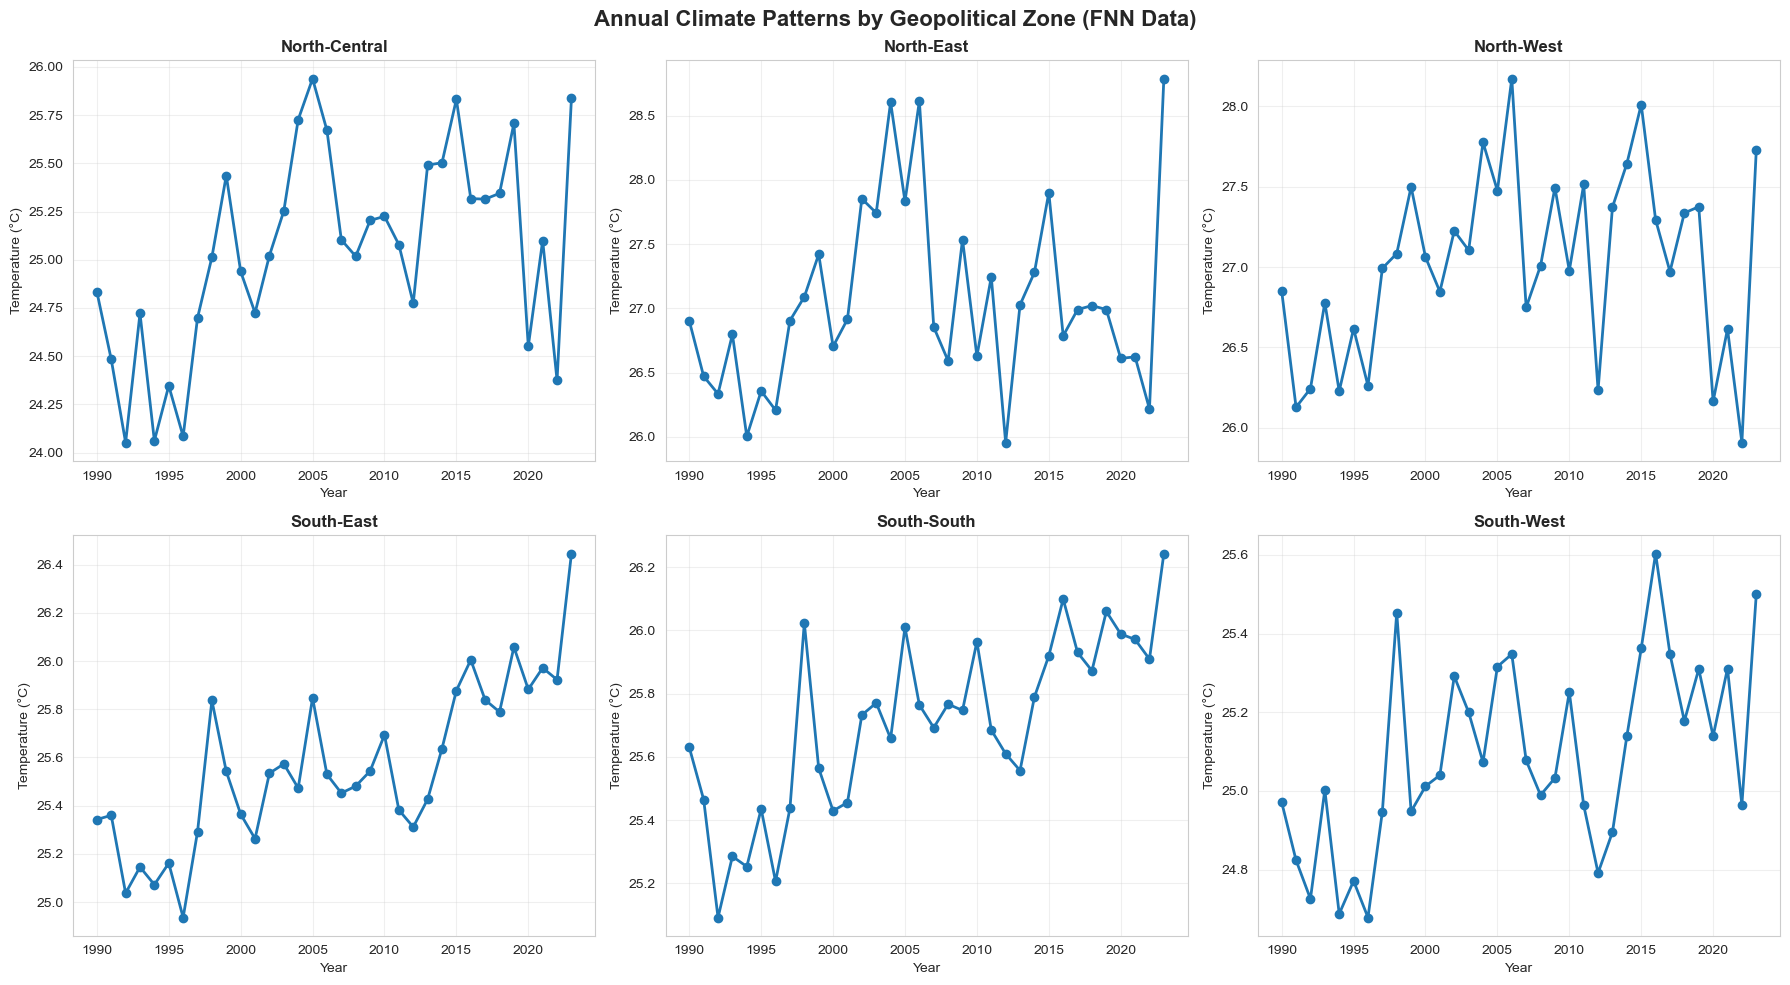

In [23]:
# Visualize data distribution by zone
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Annual Climate Patterns by Geopolitical Zone (FNN Data)', fontsize=16, fontweight='bold')

zones = fnn_master['Geopolitical_Zone'].unique()

for idx, zone in enumerate(zones):
    row = idx // 3
    col = idx % 3
    
    zone_data = fnn_master[fnn_master['Geopolitical_Zone'] == zone]
    
    # Plot average temperature over years
    yearly_temp = zone_data.groupby('Year')['Avg_Temp_C'].mean()
    axes[row, col].plot(yearly_temp.index, yearly_temp.values, marker='o', linewidth=2)
    axes[row, col].set_title(zone, fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Year')
    axes[row, col].set_ylabel('Temperature (°C)')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

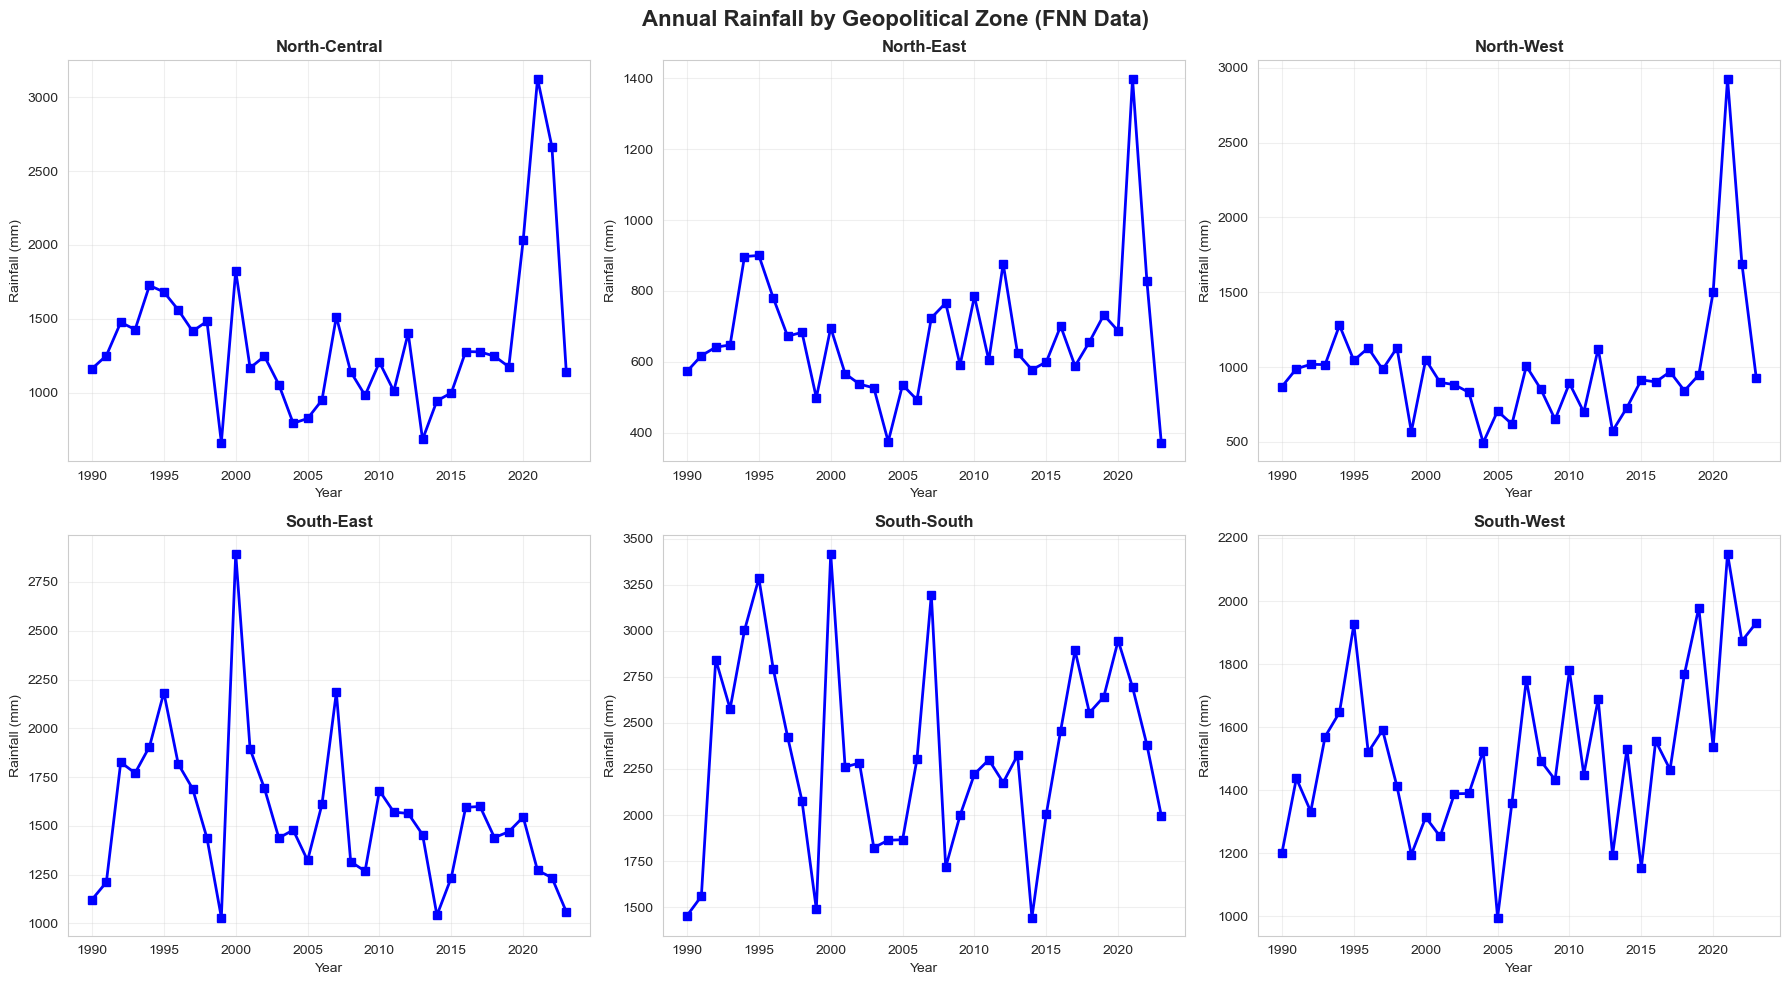

In [24]:
# Rainfall patterns by zone
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Annual Rainfall by Geopolitical Zone (FNN Data)', fontsize=16, fontweight='bold')

for idx, zone in enumerate(zones):
    row = idx // 3
    col = idx % 3
    
    zone_data = fnn_master[fnn_master['Geopolitical_Zone'] == zone]
    yearly_rain = zone_data.groupby('Year')['Rainfall_mm'].mean()
    
    axes[row, col].plot(yearly_rain.index, yearly_rain.values, marker='s', linewidth=2, color='blue')
    axes[row, col].set_title(zone, fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Year')
    axes[row, col].set_ylabel('Rainfall (mm)')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

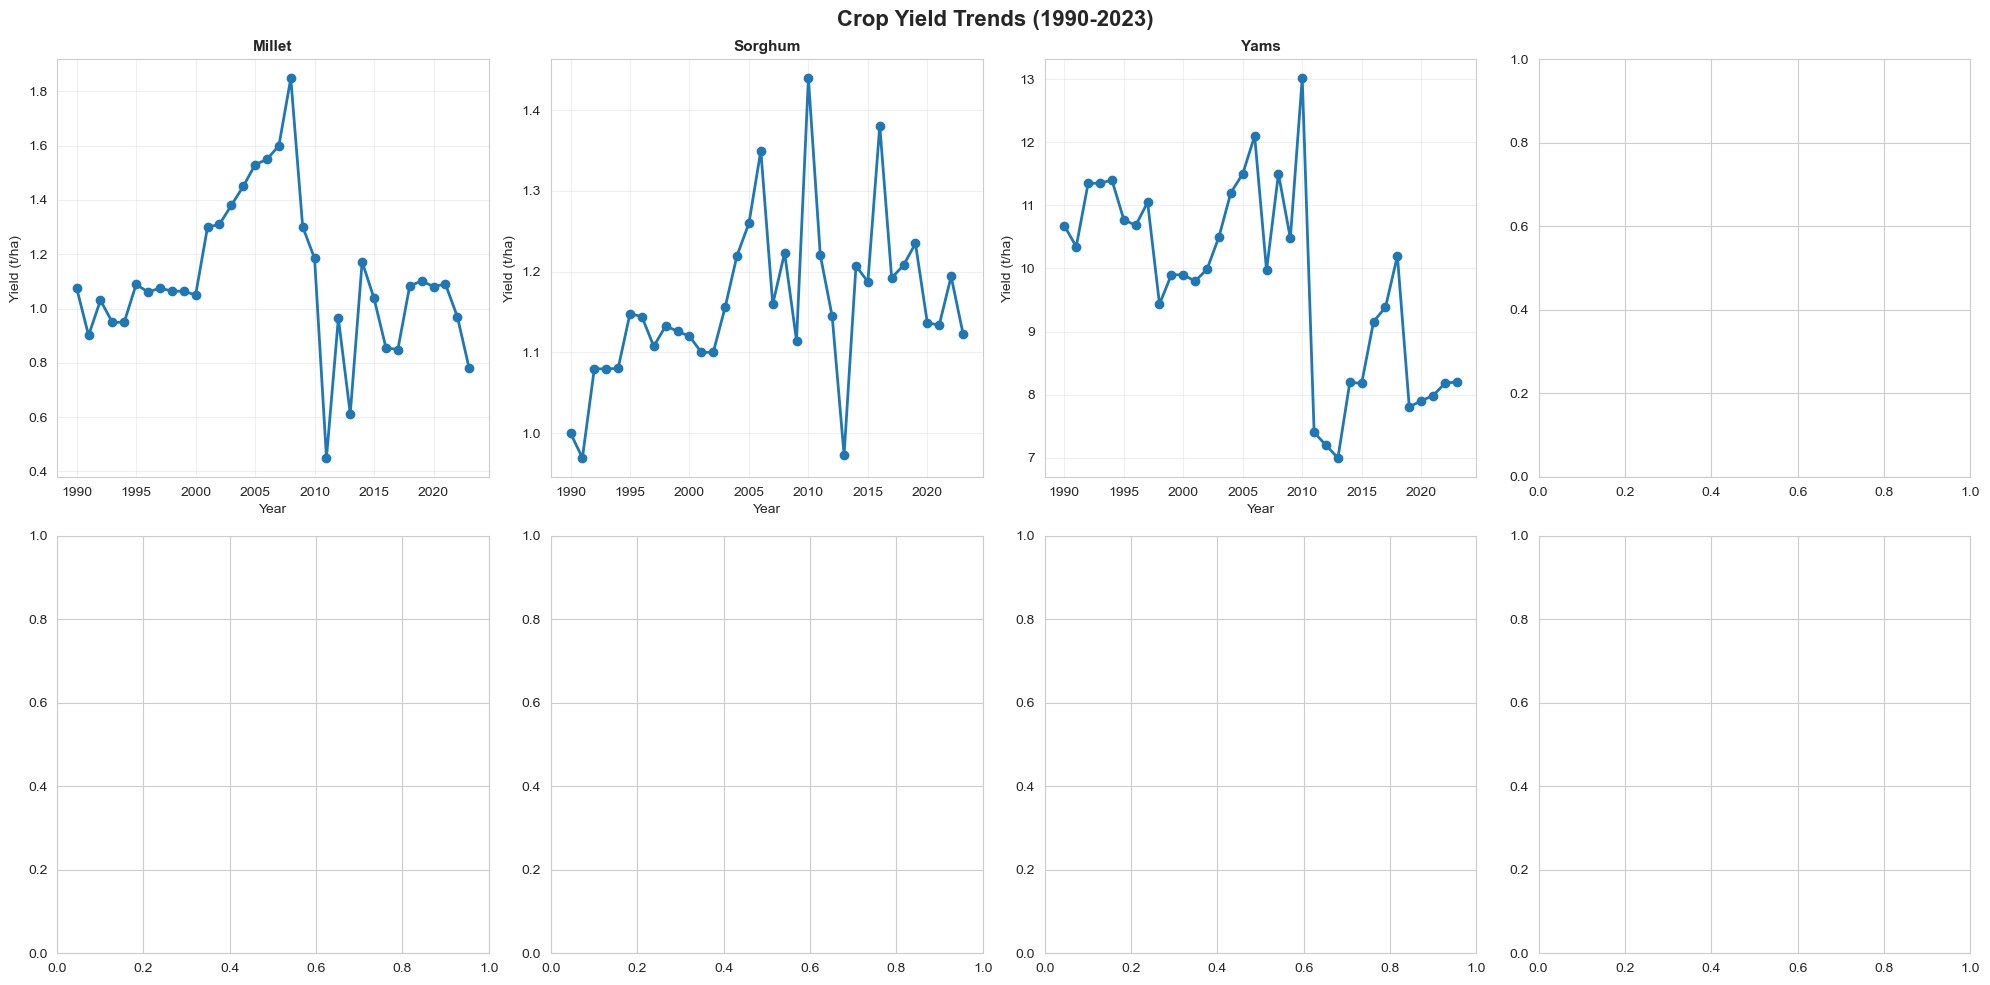

In [25]:
# Crop yield trends
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Crop Yield Trends (1990-2023)', fontsize=16, fontweight='bold')

for idx, crop in enumerate(crops):
    row = idx // 4
    col = idx % 4
    
    crop_data = yield_data_filtered[yield_data_filtered['Crop'] == crop]
    
    axes[row, col].plot(crop_data['Year'], crop_data['Yield_tonnes_per_ha'], marker='o', linewidth=2)
    axes[row, col].set_title(crop, fontsize=11, fontweight='bold')
    axes[row, col].set_xlabel('Year')
    axes[row, col].set_ylabel('Yield (t/ha)')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 11. Save Processed Datasets

In [26]:
# Create output directory
output_dir = Path('project_data/processed_data')
output_dir.mkdir(parents=True, exist_ok=True)

print("Saving processed datasets...")

# Save FNN data
fnn_output = output_dir / 'master_data_fnn.csv'
fnn_master.to_csv(fnn_output, index=False)
print(f"  ✓ FNN data saved: {fnn_output}")
print(f"    Shape: {fnn_master.shape}")

# Save LSTM data
lstm_output = output_dir / 'master_data_lstm.csv'
lstm_master.to_csv(lstm_output, index=False)
print(f"  ✓ LSTM data saved: {lstm_output}")
print(f"    Shape: {lstm_master.shape}")

# Save Hybrid data
hybrid_output = output_dir / 'master_data_hybrid.csv'
hybrid_master.to_csv(hybrid_output, index=False)
print(f"  ✓ Hybrid data saved: {hybrid_output}")
print(f"    Shape: {hybrid_master.shape}")

Saving processed datasets...
  ✓ FNN data saved: project_data\processed_data\master_data_fnn.csv
    Shape: (1836, 33)
  ✓ LSTM data saved: project_data\processed_data\master_data_lstm.csv
    Shape: (22032, 38)
  ✓ Hybrid data saved: project_data\processed_data\master_data_hybrid.csv
    Shape: (22032, 41)


In [27]:
# Save metadata
import json

metadata = {
    'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'temporal_coverage': {
        'start_year': int(fnn_master['Year'].min()),
        'end_year': int(fnn_master['Year'].max()),
        'total_years': int(fnn_master['Year'].nunique())
    },
    'spatial_coverage': {
        'geopolitical_zones': 6,
        'states': int(fnn_master['State'].nunique()),
        'zones_list': list(fnn_master['Geopolitical_Zone'].unique())
    },
    'crops': {
        'total': len(crops),
        'list': list(crops)
    },
    'datasets': {
        'fnn': {
            'description': 'Annual aggregated data for Feedforward Neural Networks',
            'shape': list(fnn_master.shape),
            'granularity': 'Annual',
            'features': list(fnn_master.columns)
        },
        'lstm': {
            'description': 'Monthly time-series data for LSTM models',
            'shape': list(lstm_master.shape),
            'granularity': 'Monthly',
            'features': list(lstm_master.columns)
        },
        'hybrid': {
            'description': 'Monthly + Static features for Hybrid models',
            'shape': list(hybrid_master.shape),
            'granularity': 'Monthly',
            'features': list(hybrid_master.columns)
        }
    },
    'splits': {
        'train': '1990-2016',
        'validation': '2017-2019',
        'test': '2020-2023'
    }
}

metadata_file = output_dir / 'preprocessing_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n  ✓ Metadata saved: {metadata_file}")


  ✓ Metadata saved: project_data\processed_data\preprocessing_metadata.json


---
## 12. Create Train/Validation/Test Splits

In [28]:
print("\n" + "="*80)
print("CREATING TRAIN/VALIDATION/TEST SPLITS")
print("="*80)

# Define split years
train_years = (1990, 2016)
val_years = (2017, 2019)
test_years = (2020, 2023)

print(f"\nTemporal splits:")
print(f"  Train: {train_years[0]}-{train_years[1]} ({train_years[1]-train_years[0]+1} years)")
print(f"  Validation: {val_years[0]}-{val_years[1]} ({val_years[1]-val_years[0]+1} years)")
print(f"  Test: {test_years[0]}-{test_years[1]} ({test_years[1]-test_years[0]+1} years)")


CREATING TRAIN/VALIDATION/TEST SPLITS

Temporal splits:
  Train: 1990-2016 (27 years)
  Validation: 2017-2019 (3 years)
  Test: 2020-2023 (4 years)


In [29]:
def create_splits(df, dataset_name):
    """Create train/val/test splits based on year ranges"""
    train = df[(df['Year'] >= train_years[0]) & (df['Year'] <= train_years[1])].copy()
    val = df[(df['Year'] >= val_years[0]) & (df['Year'] <= val_years[1])].copy()
    test = df[(df['Year'] >= test_years[0]) & (df['Year'] <= test_years[1])].copy()
    
    print(f"\n{dataset_name} Splits:")
    print(f"  Train: {train.shape}")
    print(f"  Val:   {val.shape}")
    print(f"  Test:  {test.shape}")
    
    return train, val, test

# Create splits for each dataset
fnn_train, fnn_val, fnn_test = create_splits(fnn_master, 'FNN')
lstm_train, lstm_val, lstm_test = create_splits(lstm_master, 'LSTM')
hybrid_train, hybrid_val, hybrid_test = create_splits(hybrid_master, 'Hybrid')


FNN Splits:
  Train: (1458, 33)
  Val:   (162, 33)
  Test:  (216, 33)

LSTM Splits:
  Train: (17496, 38)
  Val:   (1944, 38)
  Test:  (2592, 38)

Hybrid Splits:
  Train: (17496, 41)
  Val:   (1944, 41)
  Test:  (2592, 41)


In [30]:
# Save splits
print("\nSaving train/validation/test splits...")

# FNN splits
fnn_dir = output_dir.parent / 'train_test_split' / 'fnn'
fnn_dir.mkdir(parents=True, exist_ok=True)
fnn_train.to_csv(fnn_dir / 'train.csv', index=False)
fnn_val.to_csv(fnn_dir / 'val.csv', index=False)
fnn_test.to_csv(fnn_dir / 'test.csv', index=False)
print(f"  ✓ FNN splits saved to: {fnn_dir}")

# LSTM splits
lstm_dir = output_dir.parent / 'train_test_split' / 'lstm'
lstm_dir.mkdir(parents=True, exist_ok=True)
lstm_train.to_csv(lstm_dir / 'train.csv', index=False)
lstm_val.to_csv(lstm_dir / 'val.csv', index=False)
lstm_test.to_csv(lstm_dir / 'test.csv', index=False)
print(f"  ✓ LSTM splits saved to: {lstm_dir}")

# Hybrid splits
hybrid_dir = output_dir.parent / 'train_test_split' / 'hybrid'
hybrid_dir.mkdir(parents=True, exist_ok=True)
hybrid_train.to_csv(hybrid_dir / 'train.csv', index=False)
hybrid_val.to_csv(hybrid_dir / 'val.csv', index=False)
hybrid_test.to_csv(hybrid_dir / 'test.csv', index=False)
print(f"  ✓ Hybrid splits saved to: {hybrid_dir}")


Saving train/validation/test splits...
  ✓ FNN splits saved to: project_data\train_test_split\fnn
  ✓ LSTM splits saved to: project_data\train_test_split\lstm
  ✓ Hybrid splits saved to: project_data\train_test_split\hybrid


---
## Summary Report

In [31]:
print("\n" + "="*80)
print("DATA PREPARATION COMPLETE - SUMMARY")
print("="*80)

print("\n📊 DATASETS CREATED:")
print(f"  1. master_data_fnn.csv     - {fnn_master.shape[0]:,} rows × {fnn_master.shape[1]} cols")
print(f"     Purpose: Annual aggregated data for FNN models")
print(f"     Granularity: Annual (growing season aggregates)")

print(f"\n  2. master_data_lstm.csv    - {lstm_master.shape[0]:,} rows × {lstm_master.shape[1]} cols")
print(f"     Purpose: Monthly time-series for LSTM models")
print(f"     Granularity: Monthly")

print(f"\n  3. master_data_hybrid.csv  - {hybrid_master.shape[0]:,} rows × {hybrid_master.shape[1]} cols")
print(f"     Purpose: Monthly + static features for Hybrid models")
print(f"     Granularity: Monthly with engineered features")

print("\n📍 SPATIAL COVERAGE:")
print(f"  Geopolitical Zones: 6")
print(f"  States: {fnn_master['State'].nunique()}")
for zone in fnn_master['Geopolitical_Zone'].unique():
    n_states = fnn_master[fnn_master['Geopolitical_Zone']==zone]['State'].nunique()
    print(f"    - {zone}: {n_states} states")

print("\n🗓️ TEMPORAL COVERAGE:")
print(f"  Period: {fnn_master['Year'].min()} - {fnn_master['Year'].max()}")
print(f"  Total years: {fnn_master['Year'].nunique()}")
print(f"  Train: 1990-2016 (27 years)")
print(f"  Validation: 2017-2019 (3 years)")
print(f"  Test: 2020-2023 (4 years)")

print("\n🌾 CROPS:")
for crop in crops:
    n_records = fnn_master[fnn_master['Crop']==crop]['Yield_tonnes_per_ha'].notna().sum()
    print(f"  - {crop}: {n_records} yield records")

print("\n📁 OUTPUT STRUCTURE:")
print(f"  project_data/")
print(f"    ├── processed_data/")
print(f"    │   ├── master_data_fnn.csv")
print(f"    │   ├── master_data_lstm.csv")
print(f"    │   ├── master_data_hybrid.csv")
print(f"    │   └── preprocessing_metadata.json")
print(f"    └── train_test_split/")
print(f"        ├── fnn/")
print(f"        │   ├── train.csv")
print(f"        │   ├── val.csv")
print(f"        │   └── test.csv")
print(f"        ├── lstm/")
print(f"        │   ├── train.csv")
print(f"        │   ├── val.csv")
print(f"        │   └── test.csv")
print(f"        └── hybrid/")
print(f"            ├── train.csv")
print(f"            ├── val.csv")
print(f"            └── test.csv")

print("\n✅ NEXT STEPS:")
print("  1. Review the visualizations and data quality checks above")
print("  2. Proceed to Phase 3: Model Development")
print("     - Train FNN models using master_data_fnn.csv")
print("     - Train LSTM models using master_data_lstm.csv")
print("     - Train Hybrid models using master_data_hybrid.csv")
print("  3. Use the splits in train_test_split/ for consistent evaluation")

print("\n" + "="*80)


DATA PREPARATION COMPLETE - SUMMARY

📊 DATASETS CREATED:
  1. master_data_fnn.csv     - 1,836 rows × 33 cols
     Purpose: Annual aggregated data for FNN models
     Granularity: Annual (growing season aggregates)

  2. master_data_lstm.csv    - 22,032 rows × 38 cols
     Purpose: Monthly time-series for LSTM models
     Granularity: Monthly

  3. master_data_hybrid.csv  - 22,032 rows × 41 cols
     Purpose: Monthly + static features for Hybrid models
     Granularity: Monthly with engineered features

📍 SPATIAL COVERAGE:
  Geopolitical Zones: 6
  States: 18
    - North-Central: 3 states
    - North-East: 3 states
    - North-West: 3 states
    - South-East: 3 states
    - South-South: 3 states
    - South-West: 3 states

🗓️ TEMPORAL COVERAGE:
  Period: 1990 - 2023
  Total years: 34
  Train: 1990-2016 (27 years)
  Validation: 2017-2019 (3 years)
  Test: 2020-2023 (4 years)

🌾 CROPS:
  - Millet: 612 yield records
  - Sorghum: 612 yield records
  - Yams: 612 yield records

📁 OUTPUT STRU